# Detecting Episode Introductions

As a on demand viewer, I want to be able to skip episode introductions for any program in any series, similar to the functionality Netflix provides. 

In order to do this, a way to automatically detect the start and stop times of episode introductions would have great utility. 

## Initial Intuitions

It is likely that the sequence constituting the introduction of each episode will be the same per series, if not per program. Therefore, it would be best to classify introductions on the series level.

An introduction (or any sequence within the episode) is constituted by a sequence of images or audio that are repeated across series and are easily recognisable to humans.

Most introductions are longer than X (~5) seconds. 

Introduction sequences occur within X (~3) minutes of the episode start time. Our search should thus only consider this period.

Introductions may or may not be at the very start of the program, there may be some pre intro clips.

One way to identify the introduction will be to read all episode frames and identify the sequence that appears the most, then taking the clips that appear in this period we can classify exact start and stop times.

In [1]:
import os
import json
from difflib import SequenceMatcher

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from utils import load_data
from utils import show_frames
from utils import show_similarity
from utils import show_mean_similarity
from utils import show_images

## Loading Episodes

In [2]:
EPISODES = load_data('../data/episodes')
EPISODE_NAMES = [x.split('.')[0] for x in os.listdir('../data/episodes') if not x.startswith('.')]
print(len(EPISODES), len(EPISODES[0]), EPISODES[0][0].shape)
print(EPISODE_NAMES)

6 1500 (56, 100)
['m000c6nt', 'm000byty', 'm000cxhn', 'm000c6qs', 'm000bqkv', 'm000c6jx']


We are loading each episode as an array of frames, converted into 56x100 single color matrices. Here we can revisualise the monochrome images. The sample chosen here is a couple of episodes of Eastenders. Only the first minute of each episode is sampled here.

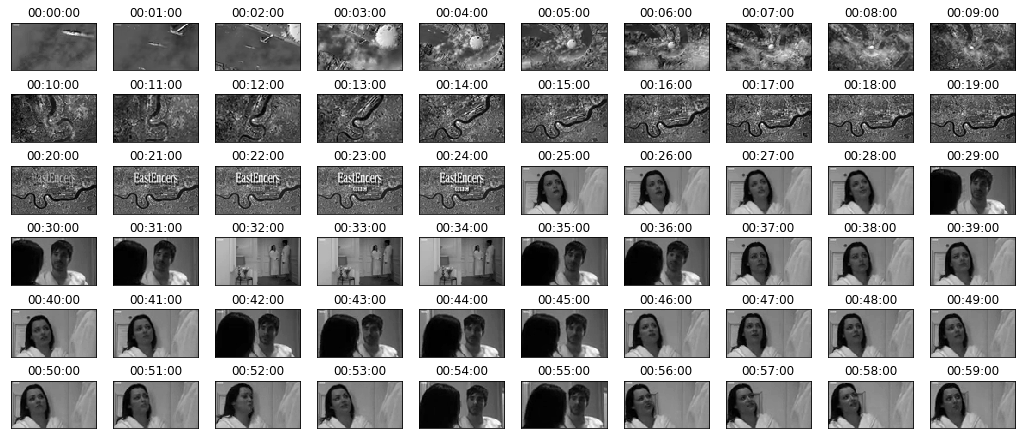

In [3]:
show_frames(EPISODES[0])

Just by eyeballing the timestamped frames we can see the intro sequence occurs about `00:00:00` - `00:24:00`. If this is the case between all episodes we should be able to pick up on this period of similarity quite easily.

## Frame Comparisons

Can we find repeated sequences across episodes at the same frame points and will this help us to identify where and what their introductions look like.

### Cosine Similarity

First method of comparison we can try is cosine similarity between frames. This will give us a way to measure angle of difference between them not the magnitude, which can be seen a comparison in a normalised space. It will give us a metric between 0 - 1, with 1 denoting orthoganality/high similarity. 

In [4]:
def frame_similarites(episodes):
    m = len(episodes[0])
    means = []
    for i in range(m):
        A = np.array([v[i].flatten() for v in episodes])
        diff = cosine_similarity(A).mean()
        means.append(diff)
    return np.array(means)

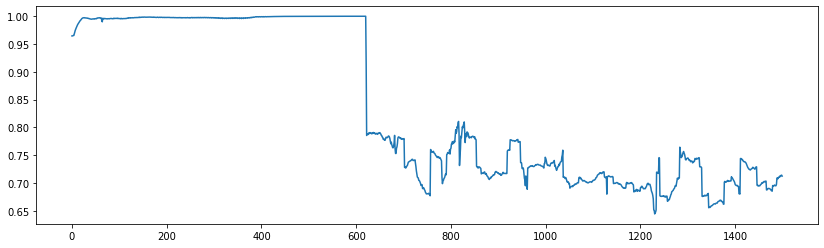

In [5]:
X = frame_similarites(EPISODES)
show_similarity(X)

Within this sample, we can see quite clearly that about the first 600 frames are similar across all videos, suggesting this is the introduction sequence we are looking for. 

It even Looks like all the videos are exactly the same here with perhaps one having a slight difference at the very begining.

We can check another episode visually to see if we are getting a similar result

Using these similarities we have made a (very) basic way of identifying the intro sequence of a program—provided all the episodes have the intro at the very begining and are all exactly the same length.

In [6]:
def extract_intro(name, episodes, fps=25, threshold=0.95):
    x = frame_similarites(episodes)
    (start, end) = find_peaks(x, fps, threshold)
    return dict(id=name, start=start, end=end)

def find_peaks(x, fps, threshold):
    start = (peak_index(min, x, threshold) / fps)
    end = (peak_index(max, x, threshold) / fps)
    return (start, end)

def peak_index(fn, ep, threshold):
    return fn(i for i, v in enumerate(ep) if v > threshold)

intro = extract_intro('Eastenders', EPISODES)
print(json.dumps(intro, indent=4))

{
    "id": "Eastenders",
    "start": 0.0,
    "end": 24.8
}


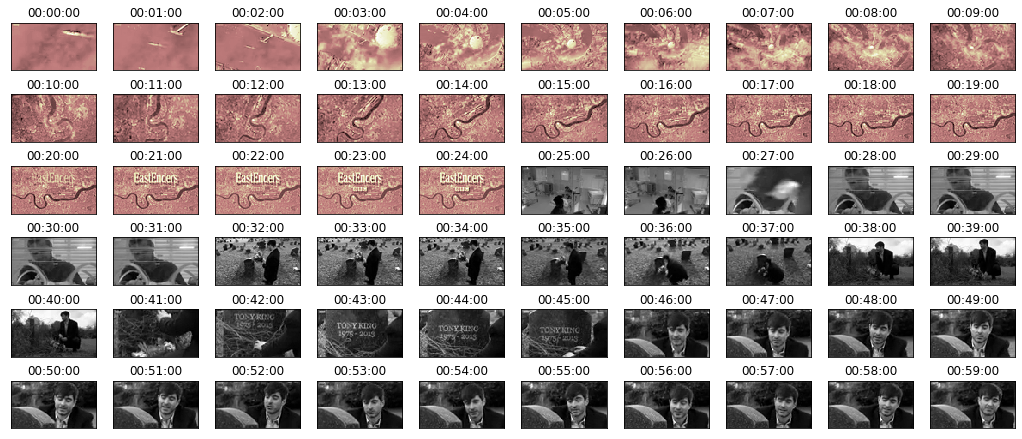

In [7]:
show_frames(EPISODES[3], intro)

We can define the above as where introductions are in our Eastenders episodes. But I think we can do better than that. For a start their might be ever so light devations of starts.

The end of our intro is normally the part we want to skip to, so matters a bit more. Also adding a buffer of a second seems like a senisble idea.

## An average intro sequence

We want a way compare what the average introduction sequence looks like, catering for any minor devations. To do this we could create a master image to compare all the other ones to. 

This will allow us to classify per episode, instead of one period for all. 

In [8]:
def mean_frames(episodes):
    means = []
    m = len(min(episodes, key=len))
    for i in range(m):
        mean = np.mean(([ep[i] for ep in episodes]), axis=0)
        means.append(mean)
    return np.array(means)

def mean_similarity(episodes, master):
    return [frame_similarites([ep, master]) for ep in episodes]

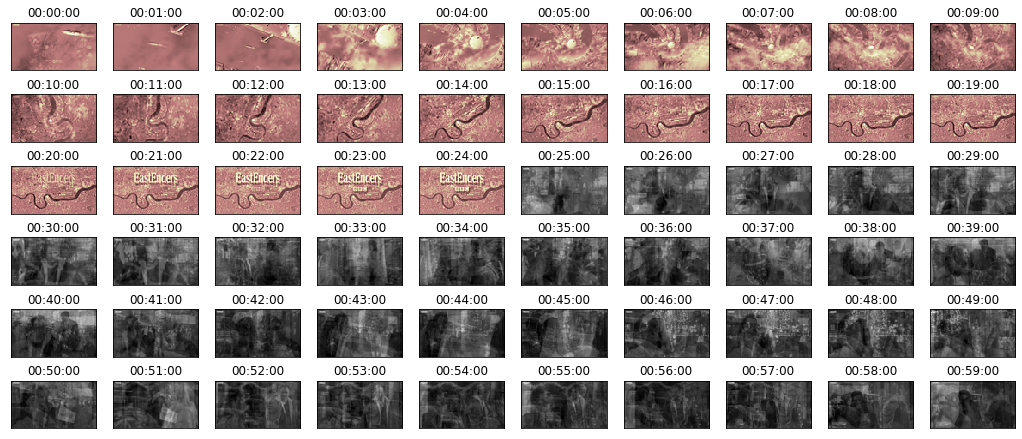

In [9]:
master = mean_frames(EPISODES)
show_frames(master, intro)

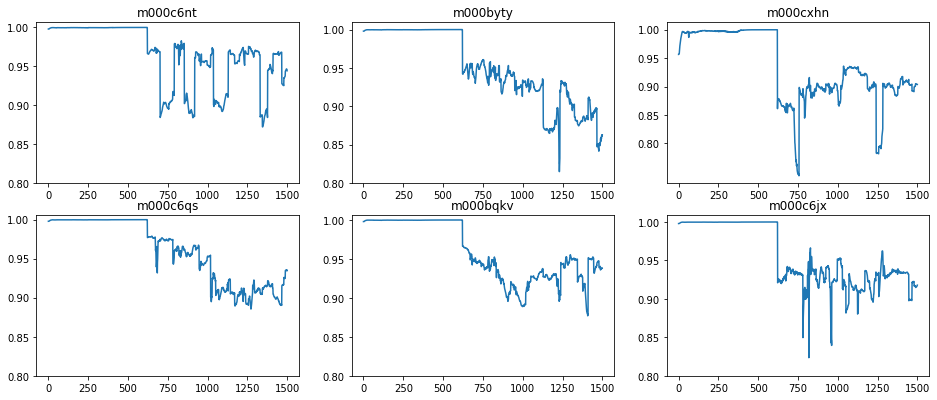

In [10]:
X = mean_similarity(EPISODES, master)
show_mean_similarity(X, EPISODE_NAMES)

In [11]:
def extract_intros(names, episodes, fps=25):
    intros = []
    master = mean_frames(episodes)
    for name, ep in zip(names, episodes):
        X = frame_similarites([ep, master])
        (start, end) = find_peaks(X, fps, threshold=0.99)
        intros.append(dict(id=name, start=start, end=end))
    return intros

In [12]:
intros = extract_intros(EPISODE_NAMES, EPISODES)
print(json.dumps(intros, indent=4))

[
    {
        "id": "m000c6nt",
        "start": 0.0,
        "end": 24.84
    },
    {
        "id": "m000byty",
        "start": 0.0,
        "end": 24.84
    },
    {
        "id": "m000cxhn",
        "start": 0.72,
        "end": 24.8
    },
    {
        "id": "m000c6qs",
        "start": 0.0,
        "end": 24.84
    },
    {
        "id": "m000bqkv",
        "start": 0.0,
        "end": 24.84
    },
    {
        "id": "m000c6jx",
        "start": 0.0,
        "end": 24.84
    }
]


# Offset intro sequences

The sample episodes we used before made it pretty easy. All the introductions fell in more or less the same place so we didn't really need to work out any offsets.

It seems likely that, in the real world, things won't be so neat and I would like a way to detect where the intro sequence is even if it comes a arbitary amount of time after the start of the program. 

Without some other samples to hand right now, I have sliced them up randomly so the intro could occur between 0-30 seconds of the program start. 

In [13]:
MIXED_EPISODES = load_data('../data/mixed/')

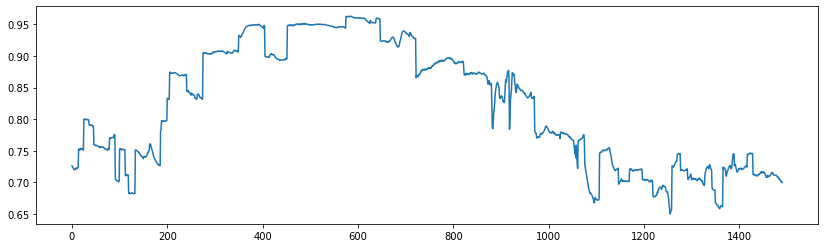

In [14]:
Xm = frame_similarites(MIXED_EPISODES)
show_similarity(Xm)

In [209]:
Xm.mean()

0.7325734953703704

Now there isn't any clear pattern when we compute the similarity between frames. There is some slight increase somewhere between 200-1000 but not any substnstial sections can be noted.

## Recognising sequences across samples

My initial intuition is that we want to identify when the matching intro sequences occur and find out how many frames they are offset by.

## Sequence matching

Luckily Python comes with a `SequenceMatcher` class in it `difflib` builtin library. We can use this to find repeat sequences between episodes. To use this out the box we have to be able to make our images hashable. To do this we have to make our images hashable. 

### Hashing episode frames

Notes:
* https://en.wikipedia.org/wiki/Hamming_distance
* https://www.pyimagesearch.com/2017/11/27/image-hashing-opencv-python/

#### Difference hashing (dhash)
There are multiple benefits of using difference hashing (dHash), but the primary ones include:

1. Our image hash won’t change if the aspect ratio of our input image changes (since we ignore the aspect ratio).
2. Adjusting brightness or contrast will either (1) not change our hash value or (2) only change it slightly, ensuring that the hashes will lie close together.
3. Difference hashing is extremely fast.

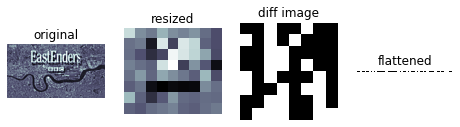

bit array: [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1]
64-bit hash: 14865372215855813924


In [15]:
frame = EPISODES[0][600]
small = cv2.resize(frame, (8 + 1, 8))
diff  = small[:, 1:] > small[:, :-1]
show_images([frame, small, diff, [diff.flatten()]], 
            ['original', 'resized', 'diff image', 'flattened'])
print('bit array:', [int(i) for i in diff.flatten()])
hashed = sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])
print('64-bit hash:', hashed)

The images above show the process that takes place using difference hashing.

The difference hash algorithm works by computing the difference (i.e., relative gradients) between adjacent pixels.

First we resize the image to a 9x8 pixel image, next we compute the differences between adjacent pixels creating a 64 pixel 8x8 image, then we flatten into a 64 bit array.

In [28]:
def hash_episodes(episodes):
    return [hash_frames(ep) for ep in episodes]

def hash_frames(episode):
    return [dhash(frame) for frame in episode]
    
def dhash(image, hash_size=8):
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [17]:
mixed_hashes = hash_episodes(MIXED_EPISODES)

## Comparing difference hashes
Here we will just use binary true/false matching.

Typically we use the Hamming distance to compare hashes. The Hamming distance measures the number of bits in two hashes that are different.

Two hashes with a Hamming distance of zero implies that the two hashes are identical (since there are no differing bits) and that the two images are identical/perceptually similar as well. It is suggested that hashes with differences > 10 bits are most likely different while Hamming distances between 1 and 10 are potentially a variation of the same image.

Using Hamming distance, is a good optimisation to explore later but for now we will just use binary matching as this is what pyhtons SequenceMatcher works with out the box.

In [18]:
seq = SequenceMatcher(a=mixed_hashes[0], b=mixed_hashes[1])
for x in seq.get_matching_blocks():
    print(x)
matches = [abs(m.a - m.b) for m in seq.get_matching_blocks() if m.size > 0]
print(matches)
m = int(sum(matches) / len(matches))
print(m)

Match(a=832, b=283, size=1)
Match(a=1075, b=525, size=9)
Match(a=1090, b=539, size=3)
Match(a=1491, b=1491, size=0)
[549, 550, 551]
550


## Aligning frames across episodes

In [19]:
def align_intros(episodes, offsets):
    aligned = []
    for (ep, z) in zip(episodes, offsets):
        x0 = np.roll(ep, z, axis=0)
        aligned.append(x0)
    return aligned

def frame_offsets(hashes):
    offsets = [0]
    base = hashes[0]
    for i in range(1, len(hashes)):
        offsets.append(find_offset(base, hashes[i]))
    return offsets

def find_offset(hash_a, hash_b):
    seq = SequenceMatcher(a=hash_a, b=hash_b)
    matches = [m.a - m.b for m in seq.get_matching_blocks() if m.size > 0]
    return int(sum(matches) / len(matches))

In [20]:
hashes  = hash_episodes(MIXED_EPISODES)
offsets = frame_offsets(hashes)
aligned = align_intros(MIXED_EPISODES, offsets)

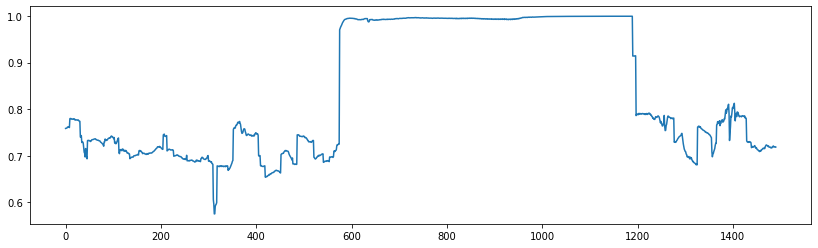

In [21]:
Xa = frame_similarites(aligned)
show_similarity(Xa)

In [22]:
Xa.mean()

0.8375482610740317

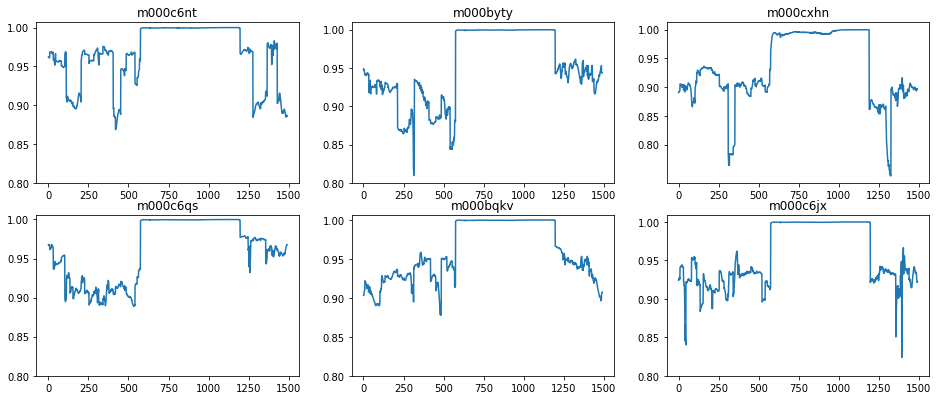

In [23]:
X = mean_similarity(aligned, mean_frames(aligned))
show_mean_similarity(X, EPISODE_NAMES)

In [24]:
def extract_intros(names, episodes, offsets, fps=25):
    intros = []
    master = mean_frames(episodes)
    for (name, ep, delta) in zip(names, episodes, offsets):
        X = frame_similarites([ep, master])
        start = (peak_index(min, X, threshold=0.99) - delta)  / fps
        end = (peak_index(max, X, threshold=0.99) - delta) / fps
        intros += [dict(id=name, start=start, end=end)]
    return intros

In [25]:
intros = extract_intros(EPISODE_NAMES, aligned, offsets)
# print(json.dumps(intros, indent=4), file=open('./data/intros/v3.json', 'w+'))
print(json.dumps(intros, indent=4))

[
    {
        "id": "m000c6nt",
        "start": 23.0,
        "end": 47.84
    },
    {
        "id": "m000byty",
        "start": 1.0,
        "end": 25.84
    },
    {
        "id": "m000cxhn",
        "start": 14.64,
        "end": 38.8
    },
    {
        "id": "m000c6qs",
        "start": 8.0,
        "end": 32.84
    },
    {
        "id": "m000bqkv",
        "start": 11.0,
        "end": 35.84
    },
    {
        "id": "m000c6jx",
        "start": 4.0,
        "end": 28.84
    }
]


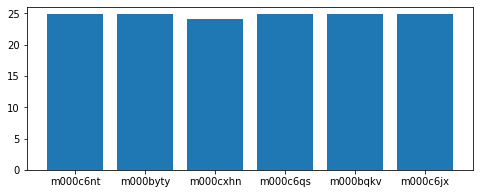

In [37]:
plt.rcParams["figure.figsize"] = [8, 3]
plt.bar(EPISODE_NAMES, [i['end'] - i['start'] for i in intros])
plt.show()

--------------- m000c6nt ---------------


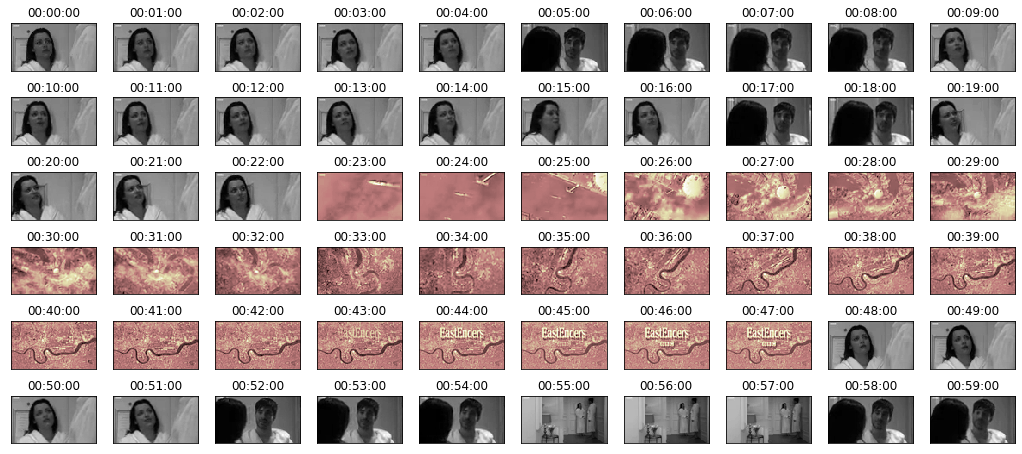

--------------- m000byty ---------------


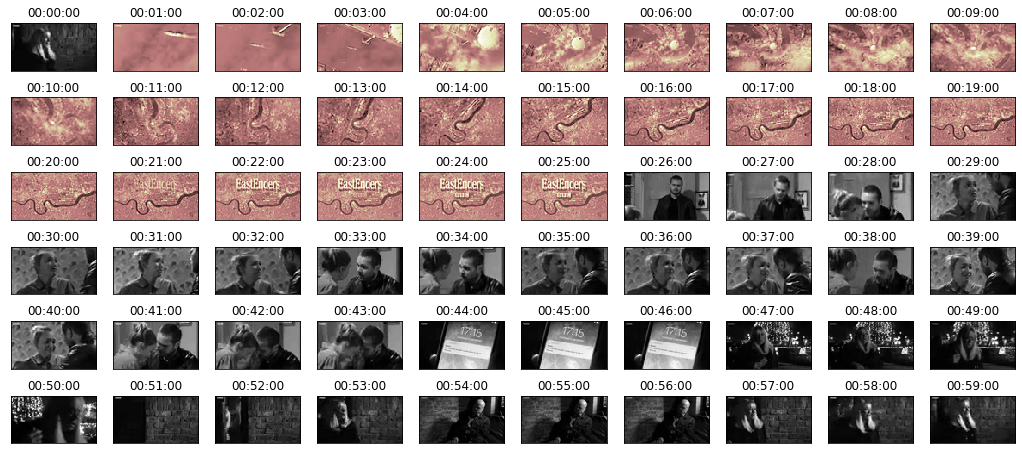

--------------- m000cxhn ---------------


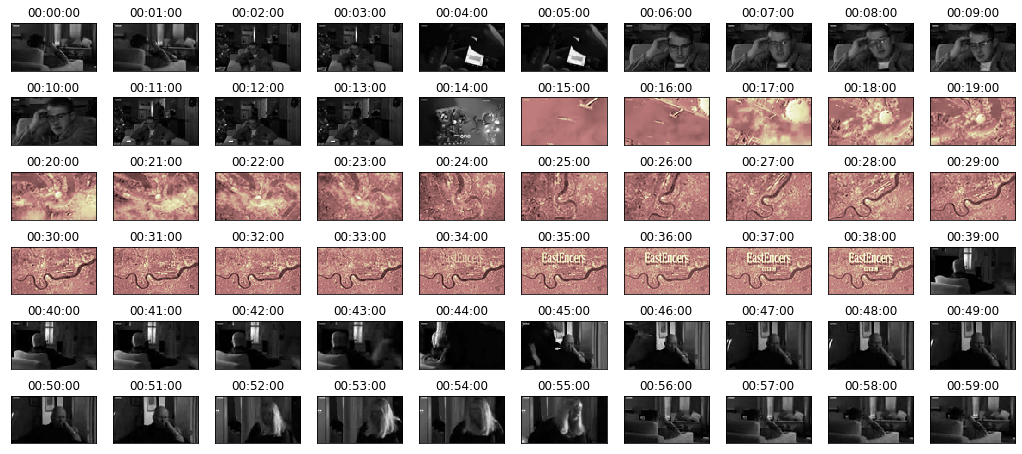

--------------- m000c6qs ---------------


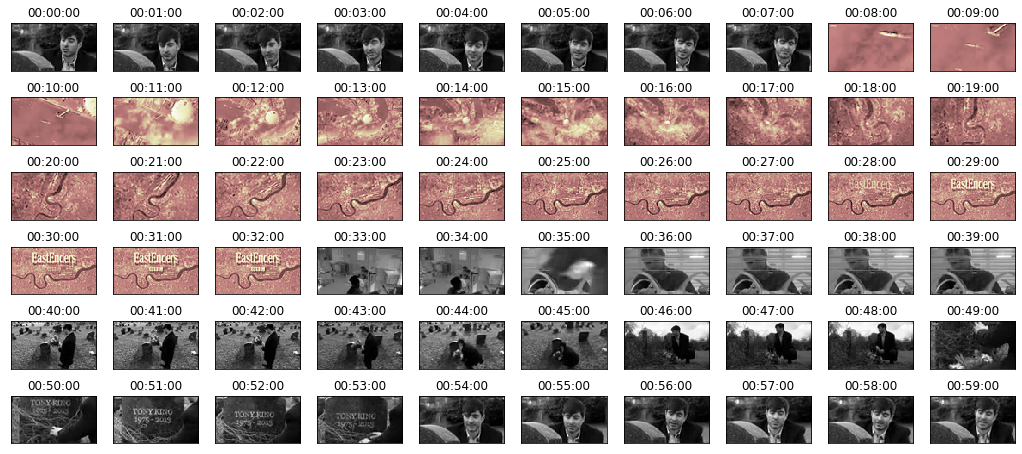

--------------- m000bqkv ---------------


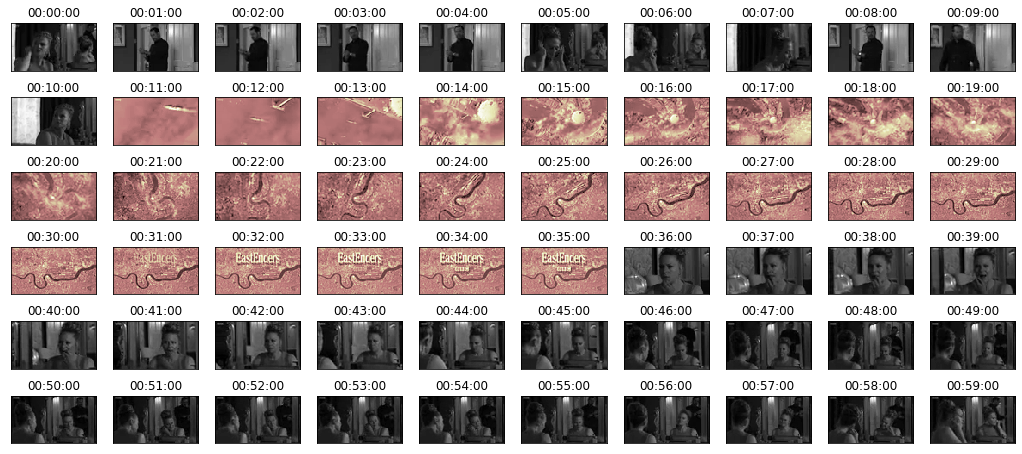

--------------- m000c6jx ---------------


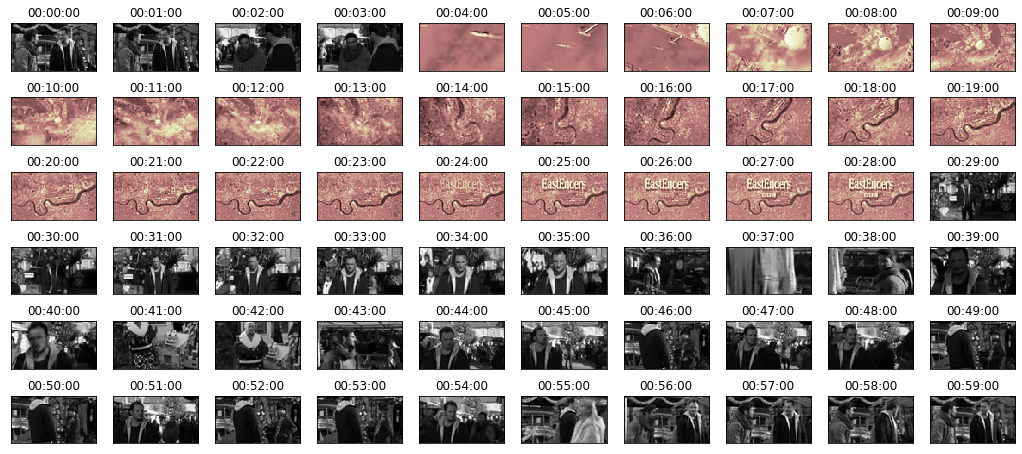

In [38]:
for ep, intro in zip(MIXED_EPISODES, intros):
    print('---------------', intro['id'], '---------------')
    show_frames(ep, intro)

## Further improvements
* Use hashed versions of images for all comparisons
    * can do in sequence matching?
    * how does accuracy compare?
    * Can use hamming distance?
* Scale down images even more, what effect does this have on accuracy?
* Better way to find descision boundry than just eyeballing?
    * Can use K-means or some other unsupervised method to identify clusters?
* Sequence matching:
    * Can we use something like hamming distance instead of binary matching images, would this produce better results?
    * What do we do if we don't find any matches?
    * how do we choose what image we should sync everything to? should we interate to try and improve accuracy?
    * how do we me make this fail and track failures?
    * we havent had to deal with long black sequences which will likely occur.
    * how do we tell if a intro is actually found apart from eyeballing.
    * How hard is it to implement our own version of pythons Sequence matcher class and make it more bespoke for this purpose?
* Do we need to compare individual images to an average image?
    * Can we just use our the times of the synced sections and apply the offsets?
    * probably dont need to do this thinking about it now?
* Scaling
    * How do we apply this to many different programs?
    * are their common characteristics we can use between series, like avg intro time.
* Testing
    * how do we actually test this?
* workflow
    * How do we make a production workflow to apply to all programs?

## Comparisons with Hamming Distance

In [32]:
from sklearn.neighbors import DistanceMetric

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

def dhash2(frame, size=8):
    resized = cv2.resize(frame, (size + 1, size))
    diff = resized[:, 1:] > resized[:, :-1]
    return np.array([int(i) for i in diff.flatten()])

hashed2 = [[dhash2(frame) for frame in ep] for ep in EPISODES]


def hamming_similarity(episodes):
    dists = []
    hamming = DistanceMetric.get_metric('hamming')
    for i in range(len(episodes[0])):
        x = 1 - hamming.pairwise([h[i] for h in episodes]).mean()
        dists.append(x)
    return np.array(dists)

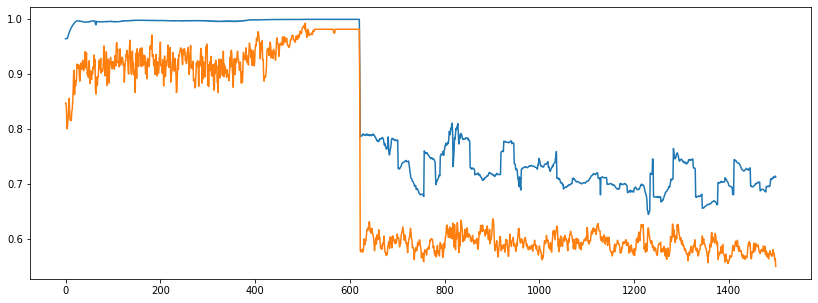

In [44]:
cosine  = frame_similarites(EPISODES)
hamming = hamming_similarity(hashed2)

plt.rcParams["figure.figsize"] = [14, 5]
plt.plot(np.arange(0, 1500), cosine, hamming)
plt.show()

## Decision boundaries

We might want want a way to more adaptively set descision boundries of wether a set of points is part of the introduction or not.

Eyeballing it kinda sucks, we want a unsupervised learning algorithm to do so.

In [45]:
from sklearn.cluster import KMeans

0.7617152197035271


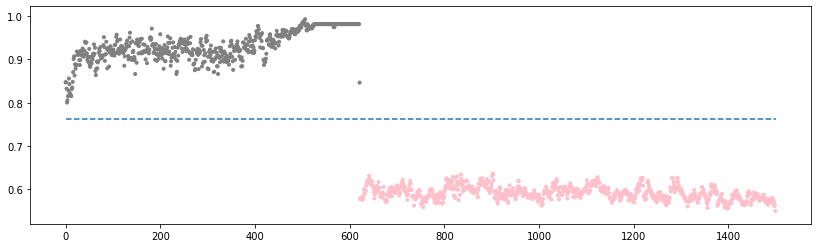

In [46]:
# Xm = frame_similarites(aligned)
# Xm = np.array(cosine)
Xm = np.array(hamming)
x = np.arange(0, len(Xm))
kmeans = KMeans(n_clusters=2, random_state=0).fit(Xm.reshape(-1,1))
colors = ['pink' if i == 1 else 'gray' for i in kmeans.labels_]

plt.rcParams["figure.figsize"] = [14,4]
plt.scatter(x, Xm, color=colors, marker='.')

# get half way between cluster centers
y = kmeans.cluster_centers_[:,0].mean()
print(y)
plt.plot([0, len(Xm)],  [y, y], '--')
plt.show()

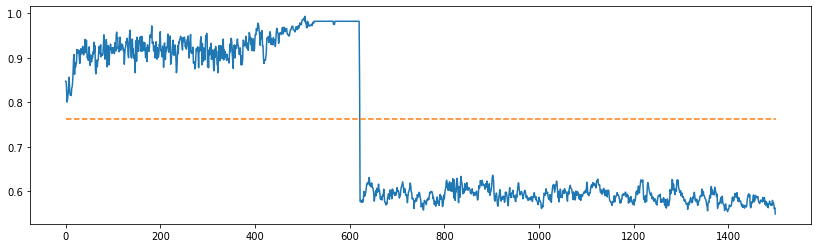

In [47]:
plt.plot(np.arange(0, 1500), Xm)
plt.plot([0, len(Xm)],  [y, y], '--')
plt.show()

https://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images


## Side note — Scene changes?

Guess: Scene changes should commonly correlate with larger differences in sequential frames, e.g a large jump from one to another rather than, slight movements.

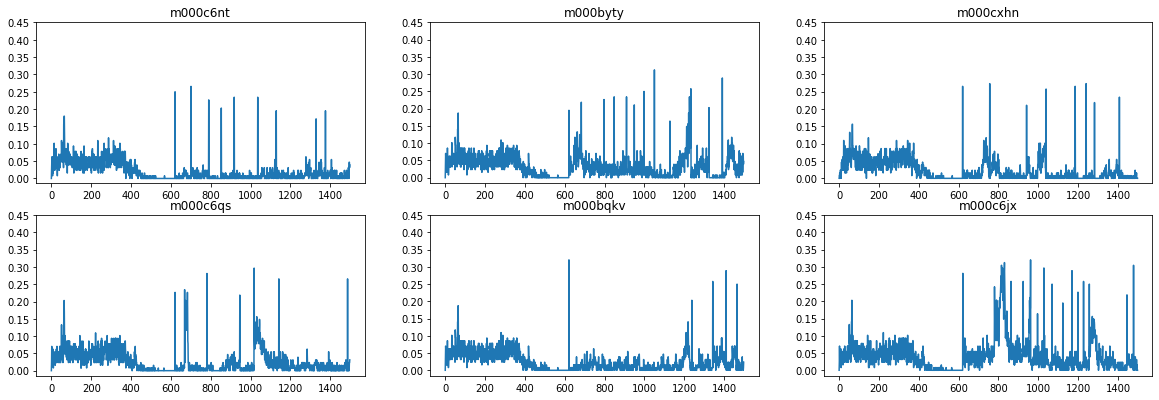

In [55]:
import math

def entropy(episode):
    p = []
    hamming = DistanceMetric.get_metric('hamming')
    for i in range(len(episode) - 1):
        x = hamming.pairwise([episode[i], episode[i+1]]).mean()
        p.append(x)
    return np.array(p)

def show_frame_similarity(X, names):
    size = len(X)
    cols = 3
    rows = math.ceil(size / cols)
    plt.rcParams["figure.figsize"] = [20, rows*3.25]
    fig, axs = plt.subplots(rows, cols)
    for i, ep in enumerate(X):
        ax = axs[i//3, i%3]
        ax.plot(np.arange(0, len(ep)), ep)
        ax.set_title(names[i])
        ax.set_yticks(np.arange(0.0, 0.5, step=0.05))
    plt.show()

changes = [entropy([dhash2(frame) for frame in _ep]) for _ep in EPISODES]
show_frame_similarity(changes, EPISODE_NAMES)